## Term Frequency-Inverse Document Frequency

$$
\text{tf-idf}(t, d) = \text{tf}(t, d) \times \text{idf}(t)
$$

where \( t \) is a term and \( d \) is a document. This TF-IDF evaluates how relevant a word (term) is to a document in a collection of documents.

1. **Term Frequency (tf(t, d))**  
   It is a term frequency that counts how many times \( t \) appears in \( d \). You can also adjust the frequency by the length of the document, which can be considered as normalization, or you can perform a log calculation as   
   
   $$
   \text{idf}(t,d) = \log({1 + count(t,d)})
   $$

2. **Inverse Document Frequency (idf(t))**  
   $$
   \text{idf}(t) = \log \left( \frac{N}{N(t)} \right)
   $$
   where \( N \) is the total number of documents and \( N(t) \) is the number of documents that contain the term \( t \). This measures how common or rare a word is in the entire document set. If the word is common, the value will be close to 0; otherwise, it will be higher. There are also many ways to calculate this. To avoid taking the log of 0, we can modify the equation above as:

   $$
   \text{idf}(t) = \log \left( \frac{N}{N(t) + 1} \right) + 1
   $$

## Objective  

I will create book recommendation system with TF-IDF method on dataset from [Kaggle](https://www.kaggle.com/datasets/arashnic/book-recommendation-dataset). I will download dataset directly from kaggle with API. This TF-IDF will recommend books based on its similarity to other book in dataset.


In [ ]:
# Install Kaggle library
! pip install kaggle

In [ ]:
# Make a directory name ".kaggle"
! mkdir ~/.kaggle

In [ ]:
# copy the kaggle.json into this new directory
! cp kaggle.json ~/.kaggle/

In [ ]:
#Allocate the required permission for this file.
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Now we are ready to download dataset from kaggle
! kaggle datasets download arashnic/book-recommendation-dataset

Dataset URL: https://www.kaggle.com/datasets/arashnic/book-recommendation-dataset
License(s): CC0-1.0
 99% 24.0M/24.3M [00:02<00:00, 19.6MB/s]
100% 24.3M/24.3M [00:02<00:00, 11.3MB/s]


In [ ]:
#Unzip the file
! unzip book-recommendation-dataset

Archive:  book-recommendation-dataset.zip
  inflating: Books.csv               
  inflating: DeepRec.png             
  inflating: Ratings.csv             
  inflating: Users.csv               
  inflating: classicRec.png          
  inflating: recsys_taxonomy2.png    


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Import library for TF-IDF and vector similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

## Data Information and Data Analysis

In [ ]:
books = pd.read_csv('Books.csv')
ratings = pd.read_csv('Ratings.csv')
Users = pd.read_csv('Users.csv')

In [ ]:
#Explore data
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [ ]:
ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [ ]:
Users.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


We will only consider the text data from **Book-Title**,**Book-Author**, **Publisher**, from books dataframe and **Location** from Users dataframe. Therefore, I will need to merge all tables. First merge rating and Users on User-ID column and then merge rating_users table with books table on ISBN column

In [ ]:
ratings_users = ratings.merge(Users, on='User-ID')
ratings_users.head()

,User-ID,ISBN,Book-Rating,Location,Age
0,276725,034545104X,0,"tyler, texas, usa",NaN
1,276726,0155061224,5,"seattle, washington, usa",NaN
2,276727,0446520802,0,"h, new south wales, australia",16.0
3,276729,052165615X,3,"rijeka, n/a, croatia",16.0
4,276729,0521795028,6,"rijeka, n/a, croatia",16.0


In [ ]:
#merge book dataframe with rating_users on ISBN column
df = books.merge(ratings_users, on='ISBN')
df.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,User-ID,Book-Rating,Location,Age
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,2,0,"stockton, california, usa",18.0
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,8,5,"timmins, ontario, canada",NaN
2,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,11400,0,"ottawa, ontario, canada",49.0
3,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,11676,8,"n/a, n/a, n/a",NaN
4,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,41385,0,"sudbury, ontario, canada",NaN


In [ ]:
#remove duplicates
print(df.shape)
df.drop_duplicates(inplace=True)
print(df.shape)

(1031136, 12)
(1031136, 12)


From above, there are no duplicate

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1031136 entries, 0 to 1031135
Data columns (total 12 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   ISBN                 1031136 non-null  object 
 1   Book-Title           1031136 non-null  object 
 2   Book-Author          1031134 non-null  object 
 3   Year-Of-Publication  1031136 non-null  object 
 4   Publisher            1031134 non-null  object 
 5   Image-URL-S          1031136 non-null  object 
 6   Image-URL-M          1031136 non-null  object 
 7   Image-URL-L          1031132 non-null  object 
 8   User-ID              1031136 non-null  int64  
 9   Book-Rating          1031136 non-null  int64  
 10  Location             1031136 non-null  object 
 11  Age                  753301 non-null   float64
dtypes: float64(1), int64(2), object(9)
memory usage: 94.4+ MB


We can see that Year-of-publication is an object which should not be, so we might need to clean it

In [ ]:
df['Year-Of-Publication'].unique()

array([2002, 2001, 1991, 1999, 2000, 1993, 1996, 1988, 2004, 1998, 1994,
       2003, 1997, 1983, 1979, 1995, 1982, 1985, 1992, 1986, 1978, 1980,
       1952, 1987, 1990, 1981, 1989, 1984, 0, 1968, 1961, 1958, 1974,
       1976, 1971, 1977, 1975, 1965, 1941, 1970, 1962, 1973, 1972, 1960,
       1966, 1920, 1956, 1959, 1953, 1951, 1942, 1963, 1964, 1969, 1954,
       1950, 1967, 2005, 1957, 1940, 1937, 1955, 1946, 1936, 1930, 2011,
       1925, 1948, 1943, 1947, 1945, 1923, 2020, 1939, 1926, 1938, 2030,
       1911, 1904, 1949, 1932, 1928, 1929, 1927, 1931, 1914, 2050, 1934,
       1910, 1933, 1902, 1924, 1921, 1900, 2038, 2026, 1944, 1917, 1901,
       2010, 1908, 1906, 1935, 1806, 2021, '2000', '1995', '1999', '2004',
       '2003', '1990', '1994', '1986', '1989', '2002', '1981', '1993',
       '1983', '1982', '1976', '1991', '1977', '1998', '1992', '1996',
       '0', '1997', '2001', '1974', '1968', '1987', '1984', '1988',
       '1963', '1956', '1970', '1985', '1978', '1973', '1980'

see Dk Publishing Inc, and Gallimard which should be publisher name in Year-of-Pubilcation

In [ ]:
df[(df['Year-Of-Publication'] == 'DK Publishing Inc') | (df['Year-Of-Publication'] == 'Gallimard')]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,User-ID,Book-Rating,Location,Age
959681,078946697X,"DK Readers: Creating the X-Men, How It All Beg...",2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.0...,http://images.amazon.com/images/P/078946697X.0...,http://images.amazon.com/images/P/078946697X.0...,NaN,169663,0,"towson, maryland, usa",NaN
959682,078946697X,"DK Readers: Creating the X-Men, How It All Beg...",2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.0...,http://images.amazon.com/images/P/078946697X.0...,http://images.amazon.com/images/P/078946697X.0...,NaN,227771,7,"savion, n/a, israel",19.0
974669,2070426769,"Peuple du ciel, suivi de 'Les Bergers\"";Jean-M...",2003,Gallimard,http://images.amazon.com/images/P/2070426769.0...,http://images.amazon.com/images/P/2070426769.0...,http://images.amazon.com/images/P/2070426769.0...,NaN,137190,0,"rennes, bretagne, france",31.0
975881,0789466953,"DK Readers: Creating the X-Men, How Comic Book...",2000,DK Publishing Inc,http://images.amazon.com/images/P/0789466953.0...,http://images.amazon.com/images/P/0789466953.0...,http://images.amazon.com/images/P/0789466953.0...,NaN,130571,0,"summerville, south carolina, usa",NaN


We can see that years are incorrectly put in Book-Author and Pubkisher name is put in Year-of Publication

In [ ]:
# Let check book-title
df[['Book-Title','Book-Author','Year-Of-Publication']][(df['Year-Of-Publication'] == 'DK Publishing Inc') | (df['Year-Of-Publication'] == 'Gallimard')]

,Book-Title,Book-Author,Year-Of-Publication
959681,"DK Readers: Creating the X-Men, How It All Beg...",2000,DK Publishing Inc
959682,"DK Readers: Creating the X-Men, How It All Beg...",2000,DK Publishing Inc
974669,"Peuple du ciel, suivi de 'Les Bergers\"";Jean-M...",2003,Gallimard
975881,"DK Readers: Creating the X-Men, How Comic Book...",2000,DK Publishing Inc


from matplotlib import pyplot as plt
import seaborn as sns
_df_0.groupby('Book-Title').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_1.groupby('Book-Author').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_2.groupby('Year-Of-Publication').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Book-Author'].value_counts()
    for x_label, grp in _df_3.groupby('Book-Title')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Book-Title')
_ = plt.ylabel('Book-Author')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Year-Of-Publication'].value_counts()
    for x_label, grp in _df_4.groupby('Book-Author')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Book-Author')
_ = plt.ylabel('Year-Of-Publication')

From Book-Title above, we can also see that the Author name is incorrectly place at the end of Book-Title column, therefore, we need to get name to be in Book-Author

In [ ]:
# cleaning data
df.loc[df.ISBN == '078946697X','Book-Author'] = 'Michael Teitelbaum'
df.loc[df.ISBN == '078946697X','Book-Title'] = 'DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)'
df.loc[df.ISBN == '078946697X','Year-Of-Publication'] = 2000
df.loc[df.ISBN == '078946697X','Publisher'] = 'DK Publishing Inc'

df.loc[df.ISBN == '2070426769','Book-Author'] = 'Jean-Marie Gustave Le ClÃ?Â©zio'
df.loc[df.ISBN == '2070426769','Book-Title'] = "Peuple du ciel, suivi de 'Les Bergers"
df.loc[df.ISBN == '2070426769','Year-Of-Publication'] = 2003
df.loc[df.ISBN == '2070426769','Publisher'] = 'Gallimard'

df.loc[df.ISBN == '0789466953','Book-Author'] = 'James Buckley'
df.loc[df.ISBN == '0789466953','Book-Title'] = 'DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)'
df.loc[df.ISBN == '0789466953','Year-Of-Publication'] = 2000
df.loc[df.ISBN == '0789466953','Publisher'] = 'DK Publishing Inc'

In [ ]:
# Let check again
df[(df['Year-Of-Publication'] == 'DK Publishing Inc') | (df['Year-Of-Publication'] == 'Gallimard')]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,User-ID,Book-Rating,Location,Age


In [ ]:
df.columns

Index(['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher',
       'Image-URL-S', 'Image-URL-M', 'Image-URL-L', 'User-ID', 'Book-Rating',
       'Location', 'Age'],
      dtype='object')

In [ ]:
#interested text columns for further analyzing by TF-IDF
columns = ['Book-Title','Book-Author','Publisher', 'Location']

#check missing values
df[columns].isnull().sum()

Book-Title     0
Book-Author    2
Publisher      2
Location       0
dtype: int64

#### Publisher

In [ ]:
#check row where book-author and publisher has missing value
df[columns][(df['Book-Author'].isnull()) | (df['Publisher'].isnull())]

,Book-Title,Book-Author,Publisher,Location
800144,A+ Quiz Masters:01 Earth,NaN,Dorling Kindersley,"milton keynes, england, united kingdom"
824210,Tyrant Moon,Elaine Corvidae,NaN,"morrow, georgia, usa"
824519,Finders Keepers,Linnea Sinclair,NaN,"morrow, georgia, usa"
929094,The Credit Suisse Guide to Managing Your Perso...,NaN,Edinburgh Financial Publishing,"selayang, selangor, malaysia"


In [ ]:
#check book author to see if we can fill in publisher name
df[columns].loc[(df['Book-Author'] == 'Elaine Corvidae'),:]


,Book-Title,Book-Author,Publisher,Location
819494,Winter's Orphans,Elaine Corvidae,Novelbooks,"morrow, georgia, usa"
824210,Tyrant Moon,Elaine Corvidae,NaN,"morrow, georgia, usa"
824460,Wolfkin,Elaine Corvidae,Hard Shell Word Factory,"morrow, georgia, usa"


In [ ]:
#check book author to see if we can fill in publisher name
df[columns].loc[(df['Book-Author'] == 'Linnea Sinclair'),:]

,Book-Title,Book-Author,Publisher,Location
824519,Finders Keepers,Linnea Sinclair,NaN,"morrow, georgia, usa"


We could not see any relationship, so we can just imput nan with "other"

In [ ]:
# replace NaN in publisher with other
df['Publisher'].fillna('other', inplace=True)
df[columns].isnull().sum()

Book-Title     0
Book-Author    2
Publisher      0
Location       0
dtype: int64

#### Book-Author

In [ ]:
df[columns].loc[(df['Book-Title'] == 'A+ Quiz Masters:01 Earth'),:]

,Book-Title,Book-Author,Publisher,Location
800144,A+ Quiz Masters:01 Earth,NaN,Dorling Kindersley,"milton keynes, england, united kingdom"


In [ ]:
df[columns].loc[(df['Book-Title'] == 'The Credit Suisse Guide to Managing Your Personal Wealth'),:]

,Book-Title,Book-Author,Publisher,Location
929094,The Credit Suisse Guide to Managing Your Perso...,NaN,Edinburgh Financial Publishing,"selayang, selangor, malaysia"


In [ ]:
# replace NaN in Book-Author with other
df['Book-Author'].fillna('other', inplace=True)
df[columns].isnull().sum()

Book-Title     0
Book-Author    0
Publisher      0
Location       0
dtype: int64

## Data Preprocessing

In [ ]:
#First make sure all columns in columns list have no case sensitive, make them all in lower case
df[columns] = df[columns].applymap(lambda x: x.lower() if type(x) == str else x)

In [ ]:
df[columns]

,Book-Title,Book-Author,Publisher,Location
0,classical mythology,mark p. o. morford,oxford university press,"stockton, california, usa"
1,clara callan,richard bruce wright,harperflamingo canada,"timmins, ontario, canada"
2,clara callan,richard bruce wright,harperflamingo canada,"ottawa, ontario, canada"
3,clara callan,richard bruce wright,harperflamingo canada,"n/a, n/a, n/a"
4,clara callan,richard bruce wright,harperflamingo canada,"sudbury, ontario, canada"
...,...,...,...,...
1031131,there's a bat in bunk five,paula danziger,random house childrens pub (mm),"providence, rhode island, usa"
1031132,from one to one hundred,teri sloat,dutton books,"orem, utah, usa"
1031133,lily dale : the true story of the town that ta...,christine wicker,harpersanfrancisco,"hopewell junction, new york, usa"
1031134,republic (world's classics),plato,oxford university press,"hopewell junction, new york, usa"


I am not considering the same book and author eventhough they might have different publisher or location. Because we only would like

In [ ]:
#drop duplicate book-title and book-author
df.drop_duplicates(subset=['Book-Title','Book-Author'], inplace=True)
df.shape

(247146, 13)

In [ ]:
#reindexing
df.reset_index(drop=True, inplace=True)
df.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,User-ID,Book-Rating,Location,Age,text
0,0195153448,classical mythology,mark p. o. morford,2002,oxford university press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,2,0,"stockton, california, usa",18.0,classical mythology mark p. o. morford oxford ...
1,0002005018,clara callan,richard bruce wright,2001,harperflamingo canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,8,5,"timmins, ontario, canada",NaN,clara callan richard bruce wright harperflamin...
2,0060973129,decision in normandy,carlo d'este,1991,harperperennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,8,0,"timmins, ontario, canada",NaN,decision in normandy carlo d'este harperperenn...
3,0374157065,flu: the story of the great influenza pandemic...,gina bari kolata,1999,farrar straus giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,8,0,"timmins, ontario, canada",NaN,flu: the story of the great influenza pandemic...
4,0393045218,the mummies of urumchi,e. j. w. barber,1999,w. w. norton &amp; company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,8,0,"timmins, ontario, canada",NaN,the mummies of urumchi e. j. w. barber w. w. n...


In [ ]:
# Concatenate text from 'Book-Title','Book-Author','Publisher', 'Location' in to one single string
df['text'] = df['Book-Title'] + ' ' + df['Book-Author'] + ' ' + df['Publisher'] + ' ' + df['Location']
df['text']

0         classical mythology mark p. o. morford oxford ...
1         clara callan richard bruce wright harperflamin...
2         decision in normandy carlo d'este harperperenn...
3         flu: the story of the great influenza pandemic...
4         the mummies of urumchi e. j. w. barber w. w. n...
                                ...                        
247141    flashpoints: promise and peril in a new world ...
247142    from one to one hundred teri sloat dutton book...
247143    lily dale : the true story of the town that ta...
247144    republic (world's classics) plato oxford unive...
247145    a guided tour of rene descartes' meditations o...
Name: text, Length: 247146, dtype: object

# Recommendation system with TF-IDF

In [ ]:
df['text'].loc[0]

# Count character in df['text'].loc[0]
len(df['text'].loc[0])


88

In [ ]:
# initialize tfidf vectorization
tfidf = TfidfVectorizer(max_features=5000)

#create a data matrix from the overviews
tfidf_matrix = tfidf.fit_transform(df['text'])
tfidf_matrix.shape

(247146, 5000)

In [ ]:
tfidf_matrix

<247146x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 2653569 stored elements in Compressed Sparse Row format>

In [ ]:
#generate a mapping from Book Title -> index (in df)
book2idf = pd.Series(df.index, index=df['Book-Title'])
book2idf

Book-Title
classical mythology                                                                                                                    0
clara callan                                                                                                                           1
decision in normandy                                                                                                                   2
flu: the story of the great influenza pandemic of 1918 and the search for the virus that caused it                                     3
the mummies of urumchi                                                                                                                 4
                                                                                                                                   ...  
flashpoints: promise and peril in a new world                                                                                     247141
from one to one hundred       

#### Test on one book

In [ ]:
#check index of one of the book
idx = book2idf["republic (world's classics)"]
idx

247144

In [ ]:
query = tfidf_matrix[idx]
query

<1x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 11 stored elements in Compressed Sparse Row format>

In [ ]:
#print query vector
query.toarray()

array([[0., 0., 0., ..., 0., 0., 0.]])

Now in our vector database each book has associated vector, so we can recommend movie that have similar vector based on the above vector.

In [ ]:
#Create score from cosine similarity between our query vector wih what we have in database tfidf_matrix
scores = cosine_similarity(query, tfidf_matrix)  #pairwise similarity
scores

array([[0.22837628, 0.        , 0.        , ..., 0.21951381, 1.        ,
        0.15304843]])

In [ ]:
#Score is now 1xN matrix, make it just a 1-D array
scores = scores.flatten()
scores

array([0.22837628, 0.        , 0.        , ..., 0.21951381, 1.        ,
       0.15304843])

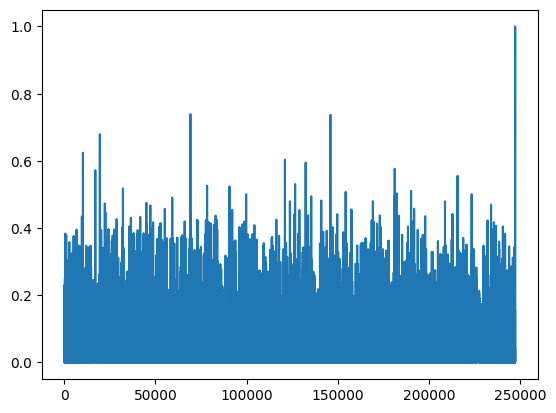

In [ ]:
plt.plot(scores)

It appear very noisy, the highest one is for the query movie, cosine similarity of two of the same vector is 1.

In [ ]:
#sort the score in descending order with most similar item at the front
(-scores).argsort() # We don't care about score value, care only how they ranks based on other

array([247144,  69144, 145853, ...,      2,      1, 247133])

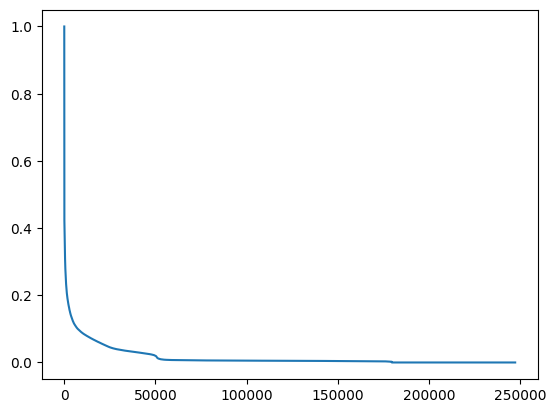

In [ ]:
plt.plot(scores[(-scores).argsort()])

In [ ]:
#Get top 5 match
#exclude self (similarity between query and itself yields max score)
top5 = (-scores).argsort()[1:6]
top5

array([ 69144, 145853,  19501, 145840,  10235])

In [ ]:
#convert indices back to title
df['Book-Title'].iloc[top5]

69144      republic (oxford world's classics)
145853        republic (the world's classics)
19501                       republic of plato
145840       phaedo (oxford world's classics)
10235     symposium (oxford world's classics)
Name: Book-Title, dtype: object

You can look for more details on author, publisher and location in each book title index

In [ ]:
# create a function that generates recommendations
def recommend_book(title):
  # get the row in the dataframe for this movie
  idx = book2idf[title]
  if type(idx) == pd.Series:
    idx = idx.iloc[0]

  # calculate the pairwise similarities for this movie
  query = tfidf_matrix[idx]
  scores = cosine_similarity(query, tfidf_matrix)

  # currently the array is 1 x N, make it just a 1-D array
  scores = scores.flatten()

  # get the indexes of the highest scoring movies
  # get the first K recommendations
  # don't return itself!
  recommended_idx = (-scores).argsort()[1:6]

  # return the titles of the recommendations
  return df['Book-Title'].iloc[recommended_idx]

In [ ]:
df['Book-Title']

0                                       classical mythology
1                                              clara callan
2                                      decision in normandy
3         flu: the story of the great influenza pandemic...
4                                    the mummies of urumchi
                                ...                        
247141        flashpoints: promise and peril in a new world
247142                              from one to one hundred
247143    lily dale : the true story of the town that ta...
247144                          republic (world's classics)
247145    a guided tour of rene descartes' meditations o...
Name: Book-Title, Length: 247146, dtype: object

In [ ]:
print("Recommendations for classical mythology:")
print(recommend_book("classical mythology"))

Recommendations for classical mythology:
103401                          classical mythology
177907                          classical mythology
50699               the oxford classical dictionary
173923    the oxford history of the classical world
173678    dictionary of mythology, mainly classical
Name: Book-Title, dtype: object


In [ ]:
#check all columns in row 103401 and row 177907
df[columns].iloc[[103401,177907]]


,Book-Title,Book-Author,Publisher,Location
103401,classical mythology,mark p.o morford,longman,"raleigh, north carolina, usa"
177907,classical mythology,mark p. o morford,longman,"vancouver, british columbia, canada"


We can see from above that we need to do another data cleaning because mark p.o morford	and mark p. o morford actually the same but the second one have space on it. This is like a real situation where we need to do another cleaning before model prediction